# Exploring Convergence
CBMOS is aimed at performing numerical studies of Center-Based overlapping Spheres Models. In this section, we present a minimal example to study the convergence of the Euler forward and Adams-Bashforth methods for a few non-proliferating cells and for three of the most popular force functions (namely GLS, Cubic and Piecewise Quadratic)  can be studied.

## Setup
After importing relevant modules, we set up the simulation parameters as well as all three models (one per force function). Each model takes three parameters: the force function to be used, the solver, and the dimension of the model (usually 2 or 3). For this simple example, we will use Euler Forward for all models.

In [1]:
import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.solvers.adams_bashforth as ab
import cbmos.cell as cl

import numpy as np
import scipy.interpolate as sci

# Simulation parameters
s = 1.0    # rest length
tf = 4.0  # final time
rA = 1.5   # maximum interaction distance
dim = 2

forces = {
    'cubic':ff.Cubic(),
    'pw. quad.':ff.PiecewisePolynomial(),
    'GLS': ff.Gls()
}

solvers = {
    'EF': ef.solve_ivp,
    'AB': ab.solve_ivp,
}

models = {
        solver_name: {
            force_name: cbmos.CBModel(
                             force,
                             solver,
                             dim,
                         )
            for force_name, force in forces.items()}
    for solver_name, solver in solvers.items()
}

## Initial Conditions
Then, we create a list a cells using a list of (x, y) coordinates. Each cell takes at least 2 parameters: a (unique) id, and some coordinates. Optional parameters can be used to define if and when each cell should proliferate. In this example, and for the sake of simplicity, we will only not use proliferation. Cells are set to be at 30% of their rest lenght. Once the simulation is launched, the cells will push each other and relax to a new configuration.

In [2]:
import numpy.random as npr

n_x = 5
n_y = 5
compactness = 0.3

initial_sheet = [
    cl.Cell(i, [compactness*x, compactness*y])
    for i, (x, y) in enumerate(
        [(x, y) for x in range(n_x) for y in range(n_y)])
]

## Model Parameters
The parameters of each force function can be set with a dictionnary containing all keywords argument to be passed to the force functions. In this case, the parameters are taken from [1], where they were set so that the relaxation time between the cells is one hour.

In [3]:
params_cubic = {
    "mu": 5.70,
    "s": s,
    "rA": rA,
}

muR = 9.1
ratio = 0.21
params_poly = {
    'muA': ratio*muR,
    'muR': muR,
    'rA': rA,
    'rR': 1.0/(1.0-np.sqrt(ratio)/3.0),
    'n': 1.0,
    'p': 1.0,
}

mu_gls=1.95
params_gls = {
    'mu': mu_gls,
    'a':-2*np.log(0.002/mu_gls),
}

params = {
    'cubic': params_cubic,
    'pw. quad.': params_poly,
    'GLS': params_gls,
}

## Reference Solutions
Here we compute the reference solutions for each force functions, using fine timesteps. The `simulate` function takes the inital configuration of the cell sheet, the time span over which to perform the simulation, the parameters to be used for the force functions, and the parameters to pass to the numerical solver.

In this case, since we are interested in measuring the error at the timesteps used by the solver, we set `raw_t` to `True`. Otherwise, the simulator would interpolate the position of the cells at the times specified in `t_data_ref`. The exact timesteps used by the solver are then returned along the history, containing the configurations of the cells at each time point. In this example we convert this history into a numpy array for efficiency.

In [4]:
dt_ref = 0.0005

N_ref = int(1/dt_ref*tf)+1
t_data_ref = np.arange(0, tf, dt_ref)

ref_traj = {}
for solver in solvers:
    for force in forces: 
        t_data_ref, history = models[solver][force].simulate(
            initial_sheet,
            t_data_ref,
            params[force],
            {'dt': dt_ref},
            raw_t=True,
        )

        ref_traj.setdefault(solver, {})[force] = np.array(
            [
                [cell.position for cell in cell_list]
                for cell_list in history
            ]
        ) # (N_ref, n_cells, dim)


## Error computation
We now compute the error between the reference solution and solutions computed with coarser timesteps.

In [5]:
dt_values = np.array([0.001*1.25**n for n in range(0, 22)])

sol = {}
for dt in dt_values:
    N = int(1/dt*tf) + 1
    t_data = np.arange(0, tf, dt)
    
    for solver in solvers:
        for force in forces:
            t_data_sol, history = models[solver][force].simulate(
                initial_sheet,
                t_data,
                params[force],
                {'dt': dt},
                raw_t=True,
            )

            traj = np.array([
                [cell.position for cell in cell_list]
                for cell_list in history
            ]) # (N, n_cells, dim)
            interp = sci.interp1d(
                t_data_sol, traj,
                axis=0,
                bounds_error=False, 
                fill_value=tuple(traj[[0, -1], :, :])
            )(t_data_ref[:])
            error = (
                np.linalg.norm(
                    interp - ref_traj[solver][force],
                    axis=0)
                /np.linalg.norm(
                    ref_traj[solver][force],
                    axis=0)
            ).mean(axis=0)

            sol.setdefault(solver, {})\
                .setdefault(force, [])\
                .append(error)

## Convergence Plot

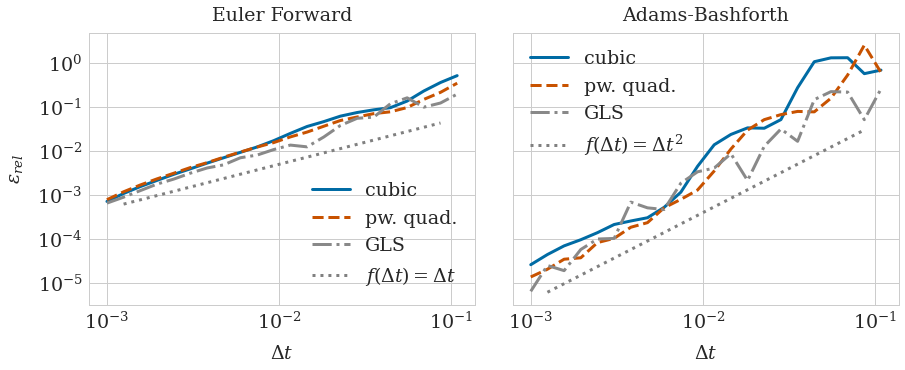

In [6]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
          'legend.fontsize': 'xx-large',
         'font.size': 11,
          'font.family': 'serif',
          "mathtext.fontset": "dejavuserif",
         'axes.titlepad': 12,
        'axes.labelpad': 12}
plt.rcParams.update(params)

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {
    'cubic': defcolors[0],
    'pw. quad.': defcolors[5],
    'GLS': defcolors[6],
}
linestyles = {
    'cubic': '-',
    'pw. quad.': '--',
    'GLS': '-.',
}

fig, ax = plt.subplots(
    1, 2,
    figsize=(14.5, 5),
    sharey=True,
    gridspec_kw={'wspace': 0.1},
)

for i, solver in enumerate(solvers):
    for force in forces: 
        ax[i].loglog(
            dt_values,
            np.sum(np.array(sol[solver][force]), axis=1),
            label=force,
            color=colors[force],
            linestyle=linestyles[force]
        )

    ax[i].set_xlabel('$\Delta t$')

ax[0].set_title('Euler Forward')
ax[1].set_title('Adams-Bashforth')

ax[0].loglog(dt_values[1:-1], dt_values[1:-1]*0.5, ':',
           label='$f(\Delta t)= \Delta t$', color='grey')
ax[1].loglog(dt_values[1:-1], dt_values[1:-1]**2*4, ':',
           label='$f(\Delta t)= \Delta t^2$', color='grey')

    
ax[0].set_ylabel('$\epsilon_{rel}$')
ax[0].legend(loc=0)
ax[1].legend(loc=0)

plt.show()

## References
1. Mathias, S., Coulier, A., Bouchnita, A., & Hellander, A. (2020). Impact of force function formulations on the numerical simulation of centre-based models. Bulletin of Mathematical Biology, 82(10), 1-43.